In [1]:
# Vallado Exploration & Test
# 2024-03-05
import kepler, math

M = 235.4
e = 0.4
M_rad = math.radians(M)
actual = math.degrees(kepler.kep_eqtnE(M_rad, e))
expected = 220.512074767522
print(actual)

220.51207476752208


# Circular Restricted 3-Body Problem<font size=2>
Earth-Moon Transfer; Curtis

Jacobi Constant: 3.1725
Initial velocity from Jacobi Constant: 0.3029738960064986 km/s


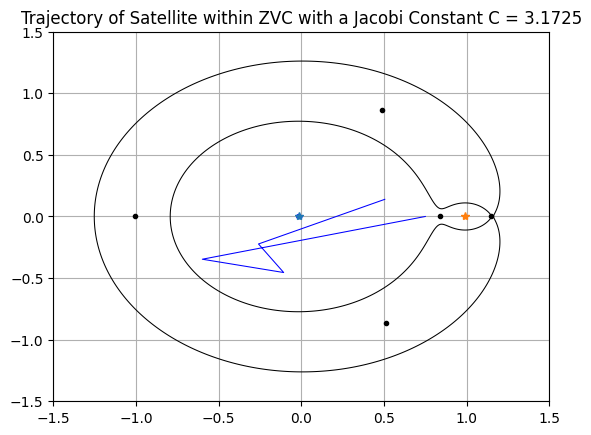

Closest approach to Moon's surface: 89692.34180848888 km
Closest approach to Earth's surface: 121604.3629203207 km
Jacobi Constant is constant to a tolerance of 4.045364669913454e-07


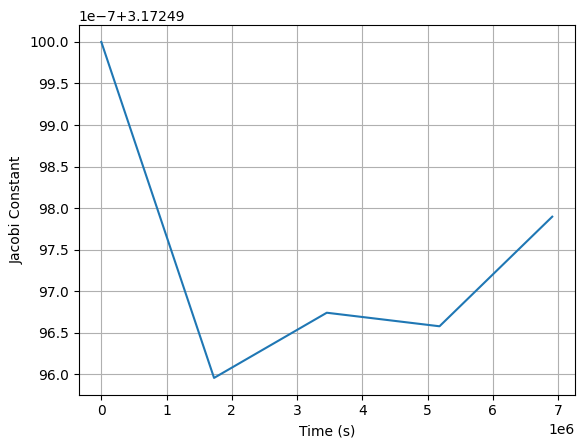

In [1]:
# Curtis; earth - moon trajectory
# From https://github.com/ImTeep/Aerospace
# https://github.com/ImTeep/Aerospace/blob/master/Trajectory.py

import numpy as np
import scipy as sci
from scipy.integrate import odeint
from matplotlib import pyplot as plt

# REAL PARAMETERS
G_real = 6.6742e-20  # Real Gravitational Constant
m1 = 5.974e24  # Mass of Earth in kg
m2 = 7.348e22  # Mass of Moon in kg
R_earth = 6378.0  # Radius of Earth in km
R_moon = 1737  # Radius of Moon in km
r12_real = 384400  # Actual distance between Earth and Moon
# --------------------------------------------

# NORMALIZED PARAMETERS
G = 1  # Normalized Gravitational Constant
r12 = 1  # Normalized distance between Earth-to-Moon
M = 1  # Normalized total mass of system
M1 = m1 / (m1 + m2)  # Normalized mass of the Earth
M2 = 1 - M1  # Normalized mass of the Moon
x1 = -M2
x2 = 1 - M2
Omega = np.sqrt(
    (G * (M1 + M2)) / (r12**3)
)  # Normalized Angular Velocity of rotating system = 1 rad/s
# ----------------------------------------------

# PARAMETERS TO CONVERT FROM NORMALIZED TO NON-NORMALIZED SYSTEM
x1_real = -M2 * r12_real  # Same as x1 above, just no longer non-dimensional
x2_real = M1 * r12_real  # Same as x2 above, just no longer non-dimensional
Omega_real = np.sqrt(
    (G_real * (m1 + m2)) / r12_real**3
)  # Actual Angular Velocity of rotating Earth-Moon system
mu1 = G_real * m1  # Real gravitational parameter of Earth
mu2 = G_real * m2  # Real gravitational parameter of Moon
# ----------------------------------------------

# Set initial conditions
L1_point = 0.8369 * r12_real  # Real location of L1 point (km)
x = 0.75 * r12_real  # Initial x-position os simulation
y = 0  # Initial y-position os simulation

C_constant = 3.1725  # <--- Actual Jacobi Constant goes here
# Jacbi Constant for Simulation; This value is used for the equations.
# However, it crresponds to the value of C used to plot the ZVC  = -2C
Jacobi_constant = -(C_constant / 2) - 0.07775
r1_real = np.sqrt((x + M2 * r12_real) ** 2 + y**2)  # Earth-to-satellite vector in km
r2_real = np.sqrt((x - M1 * r12_real) ** 2 + y**2)  # Moon-to-satellite vector in km
# initial velocity in based on position and Jacobi Constant
velocity0 = np.sqrt(
    (Omega_real**2) * (x**2 + y**2)
    + ((2 * mu1) / r1_real)
    + ((2 * mu2) / r2_real)
    + (2 * Jacobi_constant)
)

vx = velocity0 * np.cos(
    15 * (np.pi / 180)
)  # Arbitrarily split velocity into x-component
vy = velocity0 * np.sin(
    15 * (np.pi / 180)
)  # Arbitrarily split velocity into y-component

X0 = np.array([x, y, vx, vy])  # Initial condition array

# TIME FOR SIMULATION
seconds_in_day = 86400
t_initial = 0  # Initial time of simulation
t_final = 100 * seconds_in_day  # Total simulation time
dt = 5  # Individual time step
steps = t_final / dt  # Total steps in simulation, equally separated
# tspan = np.linspace(t_initial, t_final, steps)
tspan = np.arange(t_initial, t_final, steps)

print("Jacobi Constant: " + str(C_constant))
print("Initial velocity from Jacobi Constant: " + str(velocity0) + " km/s")


def get_x_dot(
    X0, t_span
):  # Get state space to be integrated: [Vx, Vy, Accel_X, Accel_Y]
    r1_real = np.sqrt(
        (X0[0] + M2 * r12_real) ** 2 + X0[1] ** 2
    )  # Updated Earth-to-satellite vector in km
    r2_real = np.sqrt(
        (X0[0] - M1 * r12_real) ** 2 + X0[1] ** 2
    )  # Updated Moon-to-satellite vector in km
    x_dot = X0[2]  # We already have x_dot --> preiously calculated vx
    y_dot = X0[3]  # We already have y_dot --> previously calculated vy
    x_ddot = (
        (2 * Omega_real * X0[3])
        + (Omega_real**2 * X0[0])
        - ((mu1 * (X0[0] - x1_real)) / r1_real**3)
        - ((mu2 * (X0[0] - x2_real)) / r2_real**3)
    )  # X-component of 3-Body gravitational acceleration; from 3-Body Equation of motion
    y_ddot = (
        -(2 * Omega_real * X0[2])
        + (Omega_real**2 * X0[1])
        - ((mu1 / r1_real**3) + (mu2 / r2_real**3)) * X0[1]
    )  # Y-component of 3-Body gravitational acceleration; from 3-Body Equation of motion
    X_dot = np.array([x_dot, y_dot, x_ddot, y_ddot])  # return new state space
    return X_dot


x_axis = np.linspace(-1.5, 1.5, 1001)  # Create grid
y_axis = np.linspace(-1.5, 1.5, 1001)  # Create grid


def CR3BP_Potential(
    M1, M2, Omega, x1, x2, x_axis, y_axis
):  # Calculate pseudo potential
    U = np.zeros((len(x_axis), len(y_axis)))
    x_counter = 0
    y_counter = 0
    for i in x_axis:
        for j in y_axis:
            r1 = np.sqrt((i - x1) ** 2 + j**2)
            r2 = np.sqrt((i - x2) ** 2 + j**2)
            U[y_counter, x_counter] = (
                -((Omega**2) / 2) * (i**2 + j**2) - (M1 / r1) - (M2 / r2)
            )
            y_counter = y_counter + 1
        y_counter = 0
        x_counter = x_counter + 1
    return U


sol = odeint(
    get_x_dot, X0, tspan
)  # INTEGRATE STATE SPACE = INTEGRATE 3-BODY EQUATIONS OF MOTION TO GET TRAJECTORY


def plot_trajectory():
    C = C_constant  # Jacobi constant for ZVC
    U = CR3BP_Potential(M1, M2, Omega, x1, x2, x_axis, y_axis)  # Calculate Potential
    plt.contour(
        y_axis,
        x_axis,
        U,
        [-C / 2, C],
        colors=("k"),
        linewidths=0.75,
        linestyles="solid",
    )  # Plot ZVC, Nondimesional

    ax = plt.gca()
    ax.plot(
        sol[:, 0] / r12_real, sol[:, 1] / r12_real, color="blue", linewidth=0.75
    )  # Normalize our trajectory to the non-dimensional coordinate system by dividing by r12_real. Plot
    ax.plot(x1, 0, "*")  # Earth, Nondimesional
    ax.plot(x2, 0, "*")  # Moon, Nondimesional
    circle1 = plt.Circle(
        (x2, 0), R_moon / r12_real, color="r", fill=False
    )  # Circle around Moon representing its surface, Nondimesional
    circle2 = plt.Circle(
        (x1, 0), R_earth / r12_real, color="b", fill=False
    )  # Circle around Earth representing its surface, Nondimesional
    ax.plot(L1_point / r12_real, 0, ".", c="k")  # L1 point, Nondimesional
    ax.plot(1.146765, 0, ".", c="k")  # L2 point, Nondimesional
    ax.plot(-1.004167, 0, ".", c="k")  # L3 point, Nondimesional
    ax.plot(0.5 + x1, np.sqrt(3) / 2.0, ".", c="k")  # L4 point, Nondimesional
    ax.plot(0.5 - x1, -np.sqrt(3) / 2.0, ".", c="k")  # L5 Point, Nondimesional
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    plt.title("Trajectory of Satellite within ZVC with a Jacobi Constant C = " + str(C))
    plt.grid()
    plt.show()


plot_trajectory()

# Get Closest approaches and see if Jacobi constant actually is constant
moon_position = x2_real
earth_position = x1_real
distance_to_moon = np.zeros((len(sol[:, 0])))
distance_to_earth = np.zeros((len(sol[:, 0])))
new_jacobi = np.zeros((len(sol[:, 0])))
for n in range(len(sol[:, 0])):
    distance_to_moon[n] = (
        np.sqrt(((sol[n, 0]) - moon_position) ** 2 + ((sol[n, 1]) ** 2)) - R_moon
    )  # Calculate distance of each point from the surface of the Moon
    distance_to_earth[n] = (
        np.sqrt(((sol[n, 0]) - earth_position) ** 2 + ((sol[n, 1]) ** 2)) - R_earth
    )  # Calculate distance of each point from the surface of the Earth
    velo = np.sqrt(sol[n, 2] ** 2 + sol[n, 3] ** 2)  # Get velocity of at each point
    r1_jacobi = np.sqrt(
        (sol[n, 0] + M2 * r12_real) ** 2 + sol[n, 1] ** 2
    )  # Updated Earth-to-satellite vector in km
    r2_jacobi = np.sqrt(
        (sol[n, 0] - M1 * r12_real) ** 2 + sol[n, 1] ** 2
    )  # Updated Moon-to-satellite vector in km
    new_jacobi[n] = (
        -(
            (velo**2)
            - ((Omega_real**2) * (sol[n, 0] ** 2 + sol[n, 1] ** 2))
            - ((2 * mu1) / (r1_jacobi))
            - ((2 * mu2) / (r2_jacobi))
        )
        - 2 * 0.07775
    )  # Calculate Jacobi constant for each point
jacobi_tolerance = np.max(new_jacobi) - np.min(new_jacobi)
moon_closest_approach = np.min(distance_to_moon)
earth_closest_approach = np.min(distance_to_earth)
print("Closest approach to Moon's surface: " + str(moon_closest_approach) + " km")
print("Closest approach to Earth's surface: " + str(earth_closest_approach) + " km")
print("Jacobi Constant is constant to a tolerance of " + str(jacobi_tolerance))


def plot_Jacobi():  # plot the Jacobi constant for each point in time
    plt.plot(tspan, new_jacobi[:])
    plt.xlabel("Time (s)")
    plt.ylabel("Jacobi Constant")
    plt.grid()
    plt.show()


plot_Jacobi()

# Orb Mech Hw3<font size=2>

Position Vector (km)= [ 13302.46265516 -13302.46265516 -18812.52309989]
Velocity Vector (km/s) = [ 2.73725757e+00  2.73725757e+00 -5.02826059e-16]


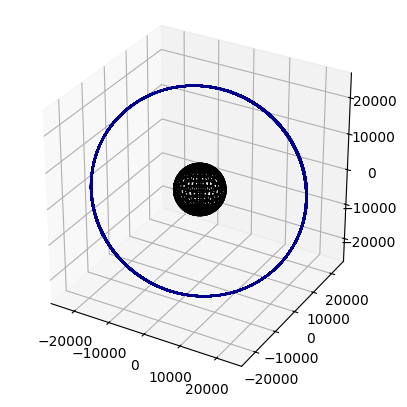

0.05037768197021


C:\Users\belue\AppData\Local\Temp\ipykernel_19092\2361367626.py:227: RuntimeWarning: invalid value encountered in arccos
  ta_hist[j] = np.arccos((h ** 2 - (u0 * r_hist[j])) / (u0 * r_hist[j] * e)) * (180.0 / np.pi)


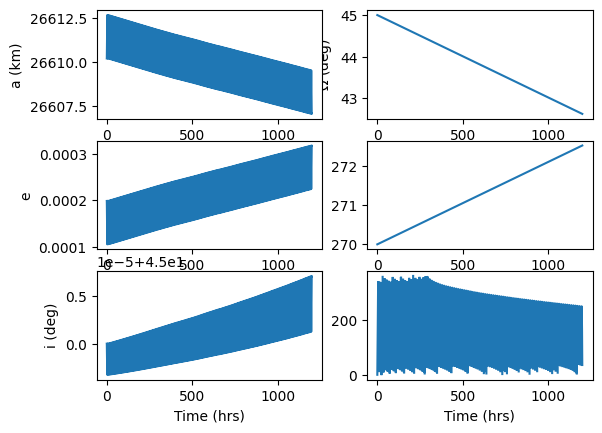

In [5]:
# From https://github.com/ImTeep/Aerospace
# File: https://github.com/ImTeep/Aerospace/blob/master/Applied_Orbital_Mechanics_HW3.py

# Pierce Jackson
# Applied Orbital Mechanics, Davide Guzzetti, September 30, 2020
# HW 3
import numpy as np
import scipy as sci
import scipy.integrate  # ode solver solve_ivp(function, t_span, y0) : tspan is interval of integration
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Problem 1 - Create algorithms to convert from Classical Orbital Elements --> Position and Velocity Vectors (COE2RV) and
# vice versa (RV2COE) ##


def COE2RV(a, e, i, RAAN, w, ta):
    # Used https://web.archive.org/web/20160418175843/https://ccar.colorado.edu/asen5070/handouts/cart2kep2002.pdf as a reference

    r = (a * (1 - e**2)) / (1 + e * np.cos(ta))  # Get position from orbit formula
    h = np.sqrt(mu * a * (1 - e**2))  # Magnitude of specific angular momentum
    X = r * (
        np.cos(RAAN) * np.cos(w + ta) - np.sin(RAAN) * np.sin(w + ta) * np.cos(i)
    )  # Position X-component
    Y = r * (
        np.sin(RAAN) * np.cos(w + ta) + np.cos(RAAN) * np.sin(w + ta) * np.cos(i)
    )  # Position Y-component
    Z = r * (np.sin(i) * np.sin(w + ta))  # Position Z-component
    p = a * (1 - e**2)  # Semilatus Rectum
    X_dot = ((X * h * e) / (r * p)) * np.sin(ta) - (
        (h / r)
        * (np.cos(RAAN) * np.sin(w + ta) + np.sin(RAAN) * np.cos(w + ta) * np.cos(i))
    )  # Velocity X-component
    Y_dot = ((Y * h * e) / (r * p)) * np.sin(ta) - (
        (h / r)
        * (np.sin(RAAN) * np.sin(w + ta) - np.cos(RAAN) * np.cos(w + ta) * np.cos(i))
    )  # Velocity Y-component
    Z_dot = ((Z * h * e) / (r * p)) * np.sin(ta) + (
        (h / r) * (np.sin(i) * np.cos(w + ta))
    )  # Velocity Z-component

    r_vector_from_COE2RV = np.array(
        [X, Y, Z]
    )  # Put X,Y,Z into an array to create a vector
    v_vector_from_COE2RV = np.array(
        [X_dot, Y_dot, Z_dot]
    )  # Put X_dot, Y_dot, Z_dot into an array to create a vector

    print("Position Vector (km)= " + str(r_vector_from_COE2RV))
    print("Velocity Vector (km/s) = " + str(v_vector_from_COE2RV))
    return (r_vector_from_COE2RV, v_vector_from_COE2RV)


def RV2COE(r_vector, v_vector):
    # Used "Orbital Mechanics for Engineering Students"  3rd Edition by Howard D. Curtis; Also used our class notes

    r = np.linalg.norm(r_vector)  # Distance
    v = np.linalg.norm(v_vector)  # MAgnitude of Velocity or Speed
    v_r = np.dot(v_vector, r_vector) / r  # radial velocity
    h_vector = np.cross(r_vector, v_vector)  # specific angular momentum vector
    h = np.linalg.norm(h_vector)  # magnitude of specific angular momentum
    i = np.arccos(h_vector[2] / h)  # inclination
    n_vector = np.cross([0, 0, 1], h_vector)  # vector pointing to ascending node
    n = np.linalg.norm(n_vector)  # magnitude of n
    if n_vector[1] > 0:
        RAAN = np.arccos(n_vector[0] / n)  # Right Ascension of the Ascending node
    if n_vector[1] < 0:
        RAAN = 2 * np.pi - np.arccos(n_vector[0] / n)
    e_vector = (1 / mu) * (
        (((v**2) - (mu / r)) * (r_vector)) - ((r * v_r) * v_vector)
    )  # eccentricity vector
    e = np.linalg.norm(e_vector)  # eccentricity
    if e_vector[2] > 0:
        w = np.arccos(np.dot(n_vector, e_vector) / (n * e))  # Argument of periapse
    if e_vector[2] < 0:
        w = 2 * np.pi - np.arccos(np.dot(n_vector, e_vector) / (n * e))
    if v_r > 0:
        ta = np.arccos((np.dot(e_vector, r_vector) / (e * r)))  # True anomaly
    if v_r < 0:
        ta = 2 * pi - np.arccos((r_vector / r) * (e_vector / e))
    Energy = (v**2 / 2) - (mu / r)
    if e == 1:
        p = h**2 / mu  # Semilatus Rectum
        return "Orbit is parabolic. Eccentricity = infinity"
    else:
        a = -mu / (2 * Energy)  # Semi-major Axis
        p = a * (1 - e**2)

    print("Semi-major Axis (km) = " + str(a))
    print("Eccentricity = " + str(e))
    print("Inclination (deg)= " + str(i * (180 / np.pi)))
    print("Right Ascension of the Ascending Node (deg) = " + str(RAAN * (180 / np.pi)))
    print("Argument of Periapse (deg)= " + str(w * (180 / np.pi)))
    print("True Anomaly (deg) = " + str(ta * (180 / np.pi)))

    return [a, e, i, RAAN, w, ta]


mu = 398600  # Gravitational Parameter of Earth km^3/s^2
r_vector = np.array([-6045.0, -3490.0, 2500.0])
v_vector = np.array([-3.457, 6.618, 2.533])


# COE = RV2COE(r_vector, v_vector)
# COE2RV(COE[0], COE[1], COE[2], COE[3], COE[4], COE[5])

# -----------------------------------------------------

## Problem 2 - Numerically propagate orbit from HW2 ##

# Gravitational Parameters
G = 6.67408e-20  # Gravitational Constant in km^3/(kg*s^2)
Me = 5.9722e24  # Mass of Earth in kg
Ms = 11110  # Mass of Satellite --> I have chosen the mass of the Hubble Space Telescope
J2 = 1.08263e-3
J3 = 2.53243e-6
theta_E = np.deg2rad(15.04 / 3600)  # rotation rate of earth in rads/s
# print(theta_E)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define Classical Orbital Elements and other variables
Re = 6378  # radius of Earth (km)
u0 = 398600  # Standard Gravitational Parameter in km^3/s^2
a = 26610.2  # Semi-major Axis
# print(a)
i = np.deg2rad(45)  # Inclination in radians (value in function in degrees)
raan = np.deg2rad(
    45
)  # Right-Ascension of the Ascending Node in radians (value in function in degrees)
w = np.deg2rad(270)  # Argument of Perigee in radians (value in function in degrees)
ta = np.deg2rad(0)  # True Anomaly in radians (value in function in degrees)
e = ((J3 * Re) / (2 * J2 * a)) * np.sin(
    i
)  # Eccentricity of orbit in degrees TAKEN FROM DISCUSSION
apogee = a * (1 + e)  # Apogee radius
perigee = a * (1 - e)  # Perigee radius
v_perigee = np.sqrt(
    2 * ((u0 / perigee) - (u0 / (2 * a)))
)  # Velcoity of spacecraft at perigee in km/s; from conservation of energy equation
h = perigee * v_perigee  # specific angular momentum of spacecraft in km^2/s
T = ((2 * np.pi) / np.sqrt(u0)) * a ** (3.0 / 2.0)  # period in seconds
T_hrs = T / 3600.0
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Calculate State Vectors r & v using the COE2RV I created above

r_X, v_X = COE2RV(
    a, e, i, raan, w, ta
)  # Position state vector (km) and Velocity state vector (km/s) of satellite in the geocentric equitorial frame (km)

r_E = np.zeros((3))  # Position state vector of Earth
v_E = np.zeros((3))  # Velocity state vector of Earth

l = np.array(
    [
        r_E[0],
        r_E[1],
        r_E[2],
        r_X[0],
        r_X[1],
        r_X[2],
        v_E[0],
        v_E[1],
        v_E[2],
        v_X[0],
        v_X[1],
        v_X[2],
    ]
)
# ------------------------------------------------
# Calculate components of acceleration of satellite from equation of motion r'' = -(u0/magnitude(r_X^3))*vector(r_X)


def TwoBodyEoM(l, t):
    r1 = l[:3]
    r2 = l[3:6]
    v1 = l[6:9]
    v2 = l[9:12]
    r = np.linalg.norm(r2 - r1)
    aj2_coefficient = (-3.0 / 2.0) * J2 * (u0 / r**2) * (Re / r) ** 2
    aj2x = aj2_coefficient * (1 - 5 * ((r2[2] / r) ** 2)) * (r2[0] / r)
    aj2y = aj2_coefficient * (1 - 5 * ((r2[2] / r) ** 2)) * (r2[1] / r)
    aj2z = aj2_coefficient * (3 - 5 * ((r2[2] / r) ** 2)) * (r2[2] / r)
    aj2 = np.array([aj2x, aj2y, aj2z])

    dv1dt = (-u0 / r**3) * r1
    dv2dt = (
        -u0 / r**3
    ) * r2 + aj2  # This is where J2 perturbation impacts the orbit. If '+aj2' is removed, the orbit is propogated without J2 perturbation.
    dr1dt = v1
    dr2dt = v2

    r_derivs = np.concatenate((dr1dt, dr2dt))
    derivs = np.concatenate((r_derivs, dv1dt, dv2dt))
    return derivs


initial_parameters = np.array(
    [
        r_E[0],
        r_E[1],
        r_E[2],
        r_X[0],
        r_X[1],
        r_X[2],
        v_E[0],
        v_E[1],
        v_E[2],
        v_X[0],
        v_X[1],
        v_X[2],
    ]
)
t_span = np.linspace(0, 100 * T, 10001)  # Time to integrate

two_body_sol = sci.integrate.odeint(
    TwoBodyEoM, initial_parameters, t_span
)  # Integrate orbit

rE_sol = two_body_sol[:, :3]
rS_sol = two_body_sol[:, 3:6]
rE_sol_velo = two_body_sol[:, 6:9]
rS_sol_velo = two_body_sol[:, 9:12]

# -------------------------------------------------
# Create Sphere at origin to represent Earth
u, v = np.mgrid[0 : 2 * np.pi : 100j, 0 : np.pi : 50j]
x_sphere = Re * np.cos(u) * np.sin(v)
y_sphere = Re * np.sin(u) * np.sin(v)
z_sphere = Re * np.cos(v)

# This function below taken from Karlo's Solution on Stack Overflow:
# https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
# check out possible solution to problem below:
# https://stackoverflow.com/questions/13685386/how-to-set-the-equal-aspect-ratio-for-all-axes-x-y-z


def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_aspect("equal")
ax.plot(rE_sol[:, 0], rE_sol[:, 1], rE_sol[:, 2], color="red")
ax.plot(rS_sol[:, 0], rS_sol[:, 1], rS_sol[:, 2], color="darkblue")
ax.plot_surface(
    x_sphere,
    y_sphere,
    z_sphere,
    rstride=3,
    cstride=3,
    color="none",
    edgecolor="k",
    shade=0,
)
set_axes_equal(ax)
plt.show()
# ------------------------------------------------
# Get time histories of Orbital elements

r_hist = np.zeros((len(two_body_sol)))
velo_hist = np.zeros((len(two_body_sol)))
ta_hist = np.zeros((len(two_body_sol)))
raan_dot = -(
    (3.0 / 2.0) * ((np.sqrt(u0) * J2 * Re**2) / (((1 - e**2) ** 2) * a ** (7.0 / 2.0)))
) * (
    np.cos(i)
)  # rate of node line regression in rad/s
raan_hist = np.zeros((len(two_body_sol)))
w_dot = raan_dot * ((5.0 / 2.0) * np.sin(i) ** 2 - 2) / np.cos(i)
w_hist = np.zeros((len(two_body_sol)))
a_hist = np.zeros((len(two_body_sol)))
e_hist = np.zeros((len(two_body_sol)))
i_hist = np.zeros((len(two_body_sol)))

print(w_dot * (180 / np.pi) * 60 * 60 * 24)
for j in range(len(two_body_sol)):
    r_hist[j] = np.sqrt(rS_sol[j, 0] ** 2 + rS_sol[j, 1] ** 2 + rS_sol[j, 2] ** 2)
    velo_hist[j] = np.sqrt(
        rS_sol_velo[j, 0] ** 2 + rS_sol_velo[j, 1] ** 2 + rS_sol_velo[j, 2] ** 2
    )
    ta_hist[j] = np.arccos((h**2 - (u0 * r_hist[j])) / (u0 * r_hist[j] * e)) * (
        180.0 / np.pi
    )
    raan_hist[j] = (raan + raan_dot * t_span[j]) * (180.0 / np.pi)
    w_hist[j] = (w + w_dot * t_span[j]) * (180.0 / np.pi)
    a_hist[j] = (1.0 / 2.0) * (
        (2 * r_hist[j] * u0) / ((2 * u0) - (velo_hist[j] ** 2 * r_hist[j]))
    )
    e_hist[j] = (-2 * a_hist[j] + 2 * apogee) / (2 * a_hist[j])
    i_hist[j] = np.arccos(
        (-2.0 / 3.0)
        * (raan_dot * (1 - e_hist[j] ** 2) ** 2 * a ** (7.0 / 2.0))
        / (np.sqrt(u0) * J2 * Re**2)
    )

ax1 = plt.subplot(3, 2, 2)
ax1.plot(t_span / 3600, raan_hist)
plt.ylabel(r"$\Omega$ (deg)")  # raw string; need to fix this

ax2 = plt.subplot(3, 2, 4)
ax2.plot(t_span / 3600, w_hist)
plt.ylabel(r"$\omega$ (deg)")  # raw string; need to fix this

ax3 = plt.subplot(3, 2, 6)
ax3.plot(t_span / 3600, ta_hist * 2)
plt.ylabel(r"$\theta$ (deg)")  # raw string; need to fix this
plt.xlabel("Time (hrs)")

ax4 = plt.subplot(3, 2, 1)
ax4.plot(t_span / 3600, a_hist)
plt.ylabel("a (km)")

ax5 = plt.subplot(3, 2, 3)
ax5.plot(t_span / 3600, e_hist)
plt.ylabel("e")

ax6 = plt.subplot(3, 2, 5)
ax6.plot(t_span / 3600, i_hist * 180.0 / np.pi)
plt.ylabel("i (deg)")
plt.xlabel("Time (hrs)")

plt.show()
# ---------------------------------------